In [1]:
import json
import os
from pycococreatortools import pycococreatortools
import numpy as np
import cv2
import matplotlib.pyplot as plt

filename_prefix="captures_"
image_witdh = 839
image_height = 380
glock_id=2
root_path='/home/m/train_glock_unity/'
files_path=os.path.join(root_path, 'Datasetde4852bb-4109-4daa-adaa-ffa049ac26e4')
files_all = os.listdir(files_path)
files_captures = []
for filename in files_all:
    if filename.startswith(filename_prefix):
        files_captures.append(os.path.join(files_path,filename))

In [3]:
print(len(annotations))

4000


In [10]:
annotations = []
images = []
is_crowd=0
i = 1000000
for filename in files_captures:
    f = open(filename, "r")
    json_dict = json.load(f)
    for capture in json_dict['captures']:
        i+=1
        coco_annotation = {}
        image_annotation = {}
        image_annotation['file_name'] = capture['filename']
        for annotation in capture['annotations']:
            
            if 'values' not in annotation.keys():
                if 'filename' in annotation.keys():
                    annotation_filename=os.path.join(root_path, annotation['filename'])
                    image=cv2.imread(annotation_filename)
                    binary_mask = cv2.inRange(image, (36, 0, 0), (255, 255,255))
                    #plt.figure()
                    #plt.imshow(binary_mask)
                    annotation_info = pycococreatortools.create_annotation_info(
                        1, 1, {'is_crowd':is_crowd, "id":i}, binary_mask,
                        (839,380), tolerance=2)
                    
                    if annotation_info is not None:
                        #print(annotation_info['segmentation'])
                        coco_annotation['segmentation'] = annotation_info['segmentation']
                    continue
            if len(annotation['values']) == 0:
                continue
            x = int(annotation['values'][0]['x'])
            y = int(annotation['values'][0]['y'])

            width = annotation['values'][0]['width']
            height = annotation['values'][0]['height']
            coco_annotation['is_crowd'] = is_crowd
            coco_annotation['id'] = i#annotation['id']
            coco_annotation['area'] = width*height
            coco_annotation['bbox'] = [x,y, width, height]
            
            coco_annotation['image_id'] = i
            coco_annotation['category_id'] = glock_id#annotation['values'][0]['instance_id']

            image_annotation['id'] = i
            image_annotation['width'] = image_witdh
            image_annotation['height'] = image_height
            image_annotation['license'] = 0
        if len(coco_annotation) and len(image_annotation):
            annotations.append(coco_annotation)
            images.append(image_annotation)

In [11]:
end_json = {}
end_json['type'] = "instances"
end_json['images'] = images
end_json['categories'] = [{"supercategory": "gun","name": "glock", "id": glock_id}]
end_json["annotations"] = annotations

In [12]:
annotation_file='/home/m/glock/annotations_glock/trainval.json'
with open(annotation_file, 'w') as f:
    json.dump(end_json, f)

In [19]:
from pycocotools.coco import COCO
import pylab
import skimage.io as io
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [20]:
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

category_names = set([category['supercategory'] for category in categories])
print('Custom COCO supercategories: \n{}'.format(' '.join(category_names)))



Custom COCO categories: 
glock

Custom COCO supercategories: 
gun


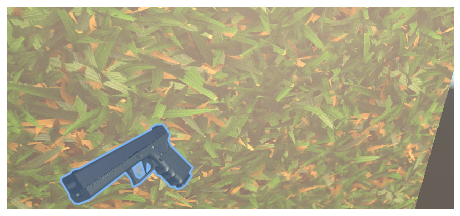

In [36]:
category_ids = coco.getCatIds(catNms=['square'])
image_ids = coco.getImgIds(catIds=category_ids)
image_data = coco.loadImgs(image_ids[np.random.randint(0, len(image_ids))])[0]
image = io.imread(root_path + image_data['file_name'])
plt.imshow(image); plt.axis('off')
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
annotation_ids = coco.getAnnIds(imgIds=image_data['id'], catIds=category_ids, iscrowd=None)
annotations = coco.loadAnns(annotation_ids)
coco.showAnns(annotations)